# Using Google mobility data

In this notebook we detail how we converted the raw Google relative mobility data (Google 2020) into epidemiologically relevant contact rates for modelling transmission rates.

The first step is to load the relevant Julia packages and the data from the `/data` folder, and disaggregating the mobility data for Nairobi, Mombasa, and the Kenya-wide representative data.

In [2]:
using CSV,DataFrames,Plots,Dates,Statistics,JLD2,Polynomials
using Plots.PlotMeasures
pyplot() #Choosing Pyplot as the plotting backend

mobilitydata_kenya = DataFrame!(CSV.File("../data/Kenya_Mobility_Report_25082020.csv"))

Kenyawide = mobilitydata_kenya[(ismissing.(mobilitydata_kenya.sub_region_1)).&(ismissing.(mobilitydata_kenya.metro_area)),:]
nairobidata = mobilitydata_kenya[(mobilitydata_kenya.sub_region_1 .=="Nairobi County").&(.~ismissing.(mobilitydata_kenya.sub_region_1)),:]
mombasadata = mobilitydata_kenya[(mobilitydata_kenya.sub_region_1 .=="Mombasa County").&(.~ismissing.(mobilitydata_kenya.sub_region_1)),:]

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code
,String,String,String?,Missing,String?,String?
1,KE,Kenya,Mombasa County,missing,missing,KE-28
2,KE,Kenya,Mombasa County,missing,missing,KE-28
3,KE,Kenya,Mombasa County,missing,missing,KE-28
4,KE,Kenya,Mombasa County,missing,missing,KE-28
5,KE,Kenya,Mombasa County,missing,missing,KE-28
6,KE,Kenya,Mombasa County,missing,missing,KE-28
7,KE,Kenya,Mombasa County,missing,missing,KE-28
8,KE,Kenya,Mombasa County,missing,missing,KE-28
9,KE,Kenya,Mombasa County,missing,missing,KE-28


Google uses six different categories for different settings where the rate of people visiting/spending time has relative to the same date in 2019 has been tracked:  
* Retail and recreation 
* Grocery and pharmacy
* Parks
* Transit
* Workplace
* Residential

We define a plotting method for this data and display 7-day moving averages (to average over weekend effects) for each category.

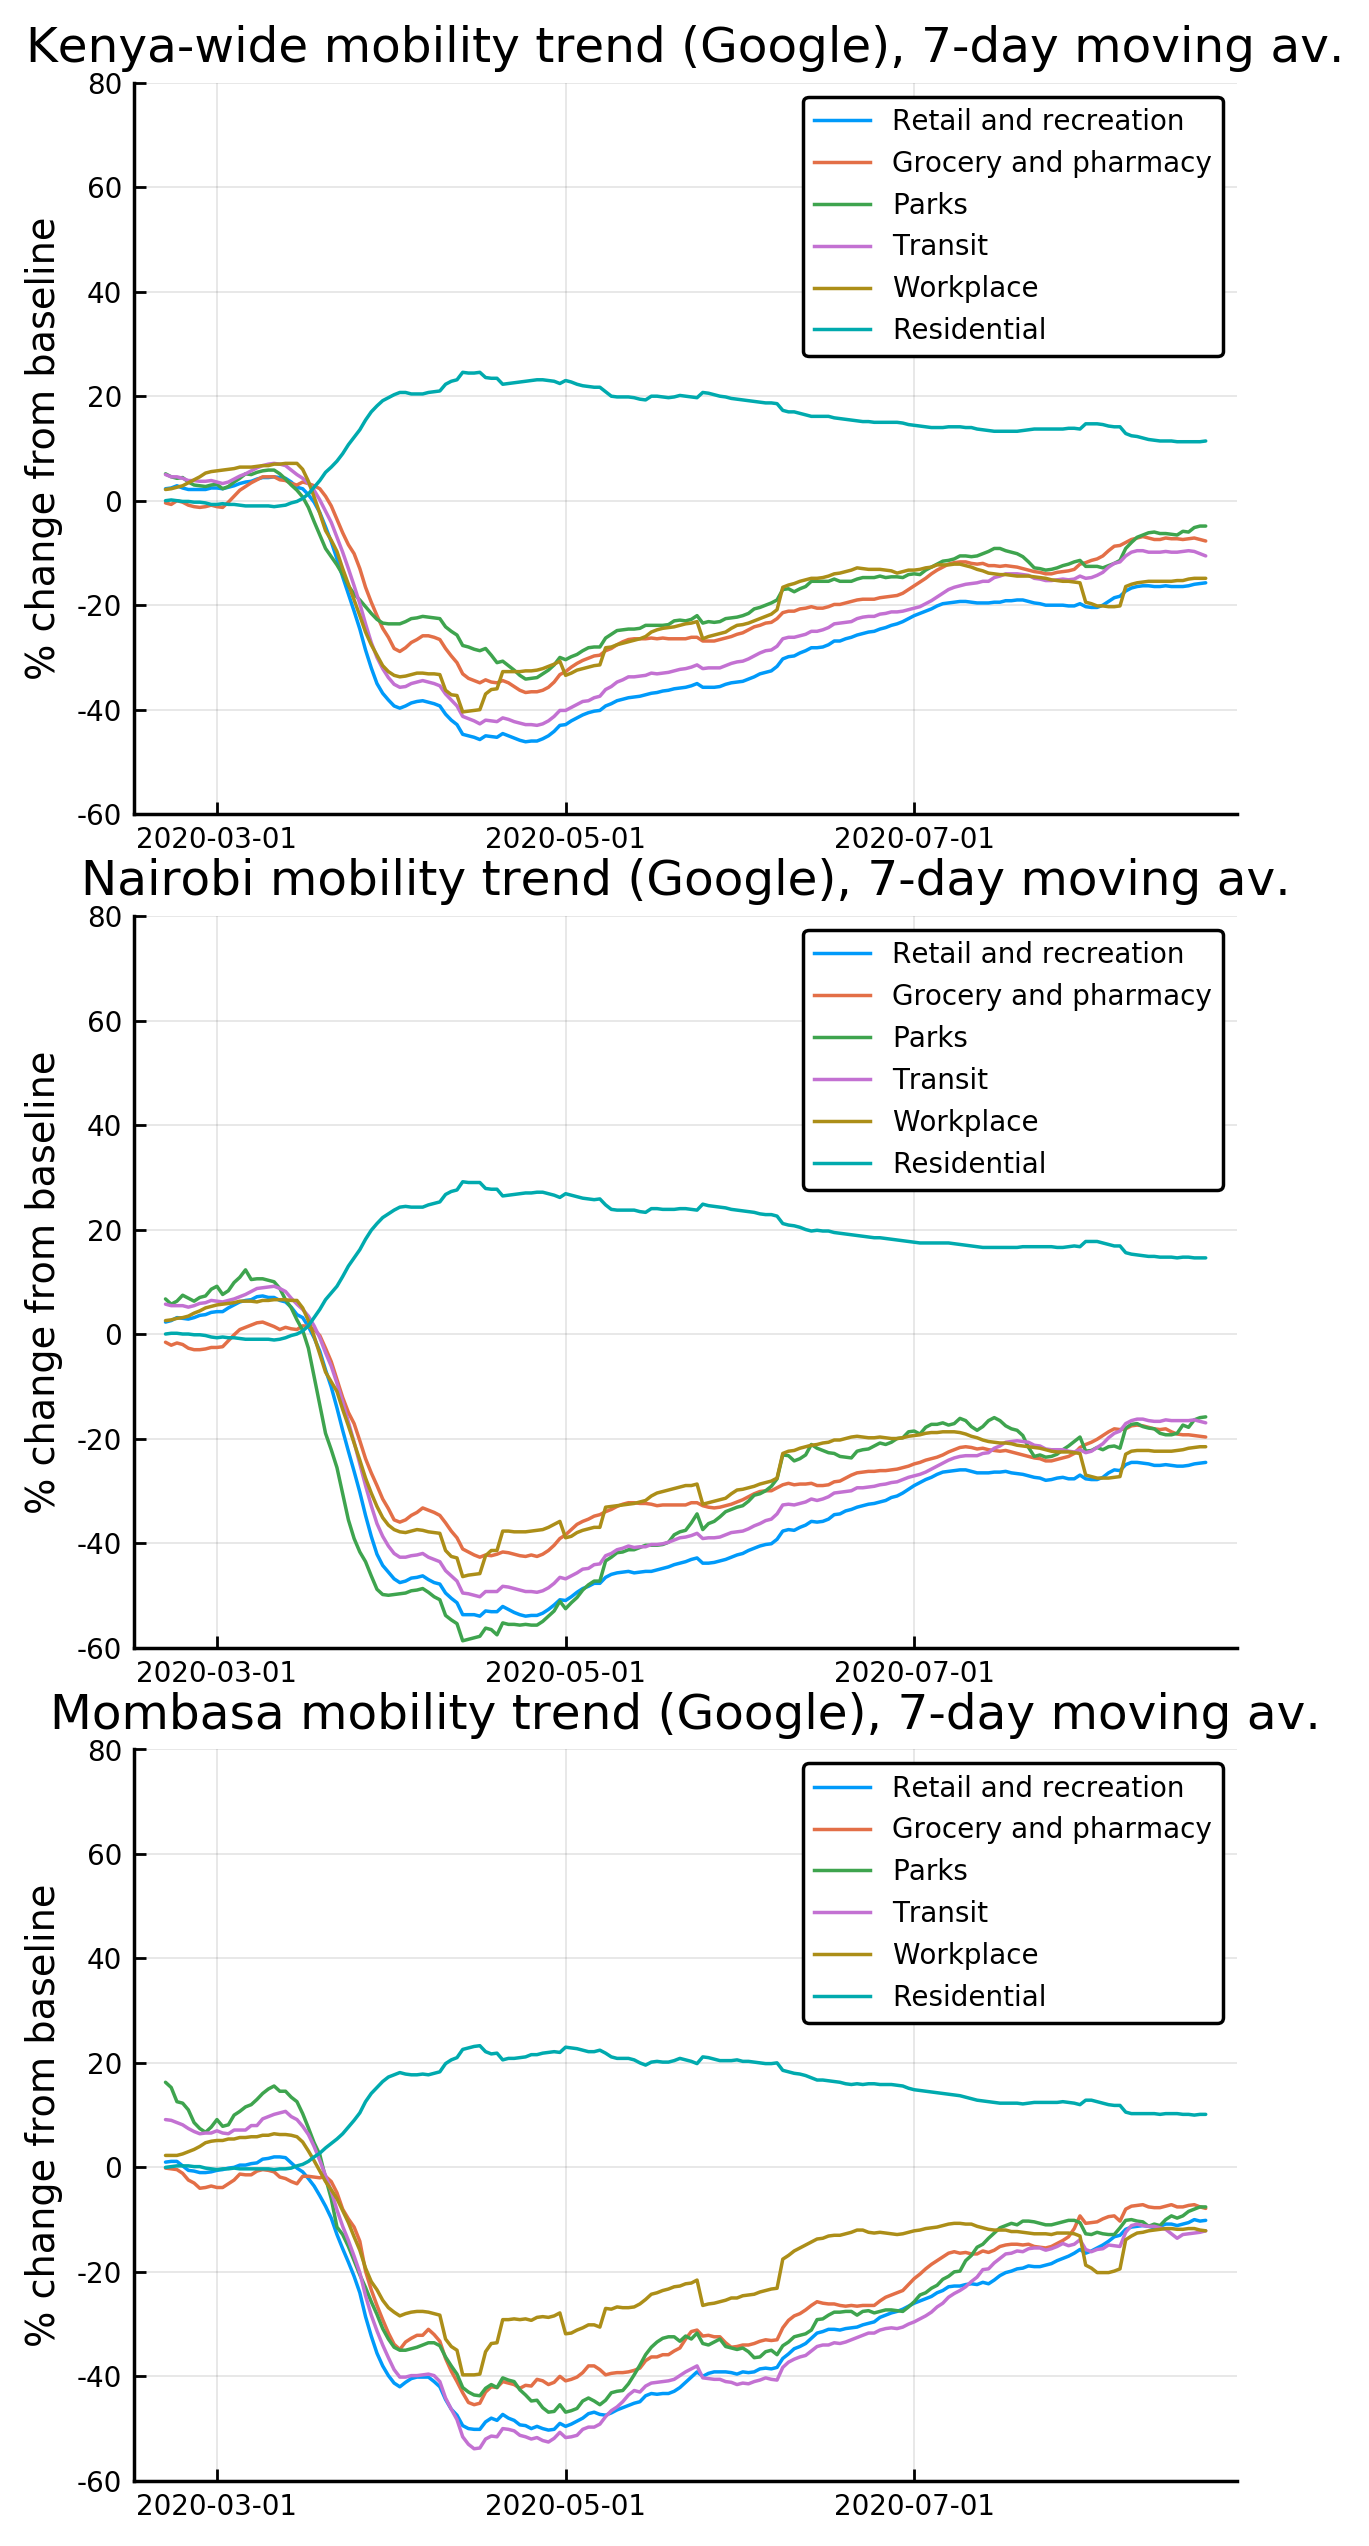

In [24]:
function sma(a::Array, n::Int)
    vals = zeros(size(a,1) - (n-1), size(a,2))

    for i in 1:size(a,1) - (n-1)
        for j in 1:size(a,2)
            vals[i,j] = mean(a[i:i+(n-1),j])
        end
    end

    vals
end

function plot_mobilitytrends(df,title_str,n)
    plt = plot(df.date[n:end],sma(Matrix(df[:,9:end]),n),
        lab = ["Retail and recreation" "Grocery and pharmacy" "Parks" "Transit" "Workplace" "Residential"],
        ylims = (-60,80),
        lw = 1,
        ylabel = "% change from baseline",
        title = title_str*", $(n)-day moving av.",
        size = (700,500),dpi = 250)
#     plot!(plt,df.date[n:end],sma(mean(Matrix(df[:,[9,10,12,13]]),dims = 2),n),
#         lab = "Risky contacts",
#         ylims = (-60,80),
#         lw = 2,
#         color = :black,
#         ls = :dash,
#         ylabel = "% change from baseline",
#         title = title_str*", $(n)-day moving av.",
#         size = (700,500),dpi = 250)
    return plt
end

plt_kenyawide = plot_mobilitytrends(Kenyawide,"Kenya-wide mobility trend (Google)",7);
plt_nairobi = plot_mobilitytrends(nairobidata,"Nairobi mobility trend (Google)",7);
plt_mombasa = plot_mobilitytrends(mombasadata,"Mombasa mobility trend (Google)",7);
layout = @layout [a;b;c]
plt_contact_rate = plot(plt_kenyawide,plt_nairobi,plt_mombasa,layout = layout,
        size = (500,1000),dpi=250)
savefig("overall_mobility_trends.pdf")

Transmission of SARS-CoV-2 has been linked to contacts occurring in indoors settings, especially crowded environments. Therefore, in this paper we use an aggregated measure of relative mobility over the "Retail and recreation", "Grocery and pharmacy", "Transit", and "Workplace" settings. This aggregated measure of epidemiologically relevant mobility is projected into the future using a simple linear projection from 1st July. Although, we also assume that the future contact rate will not exceed its 2019 baseline.

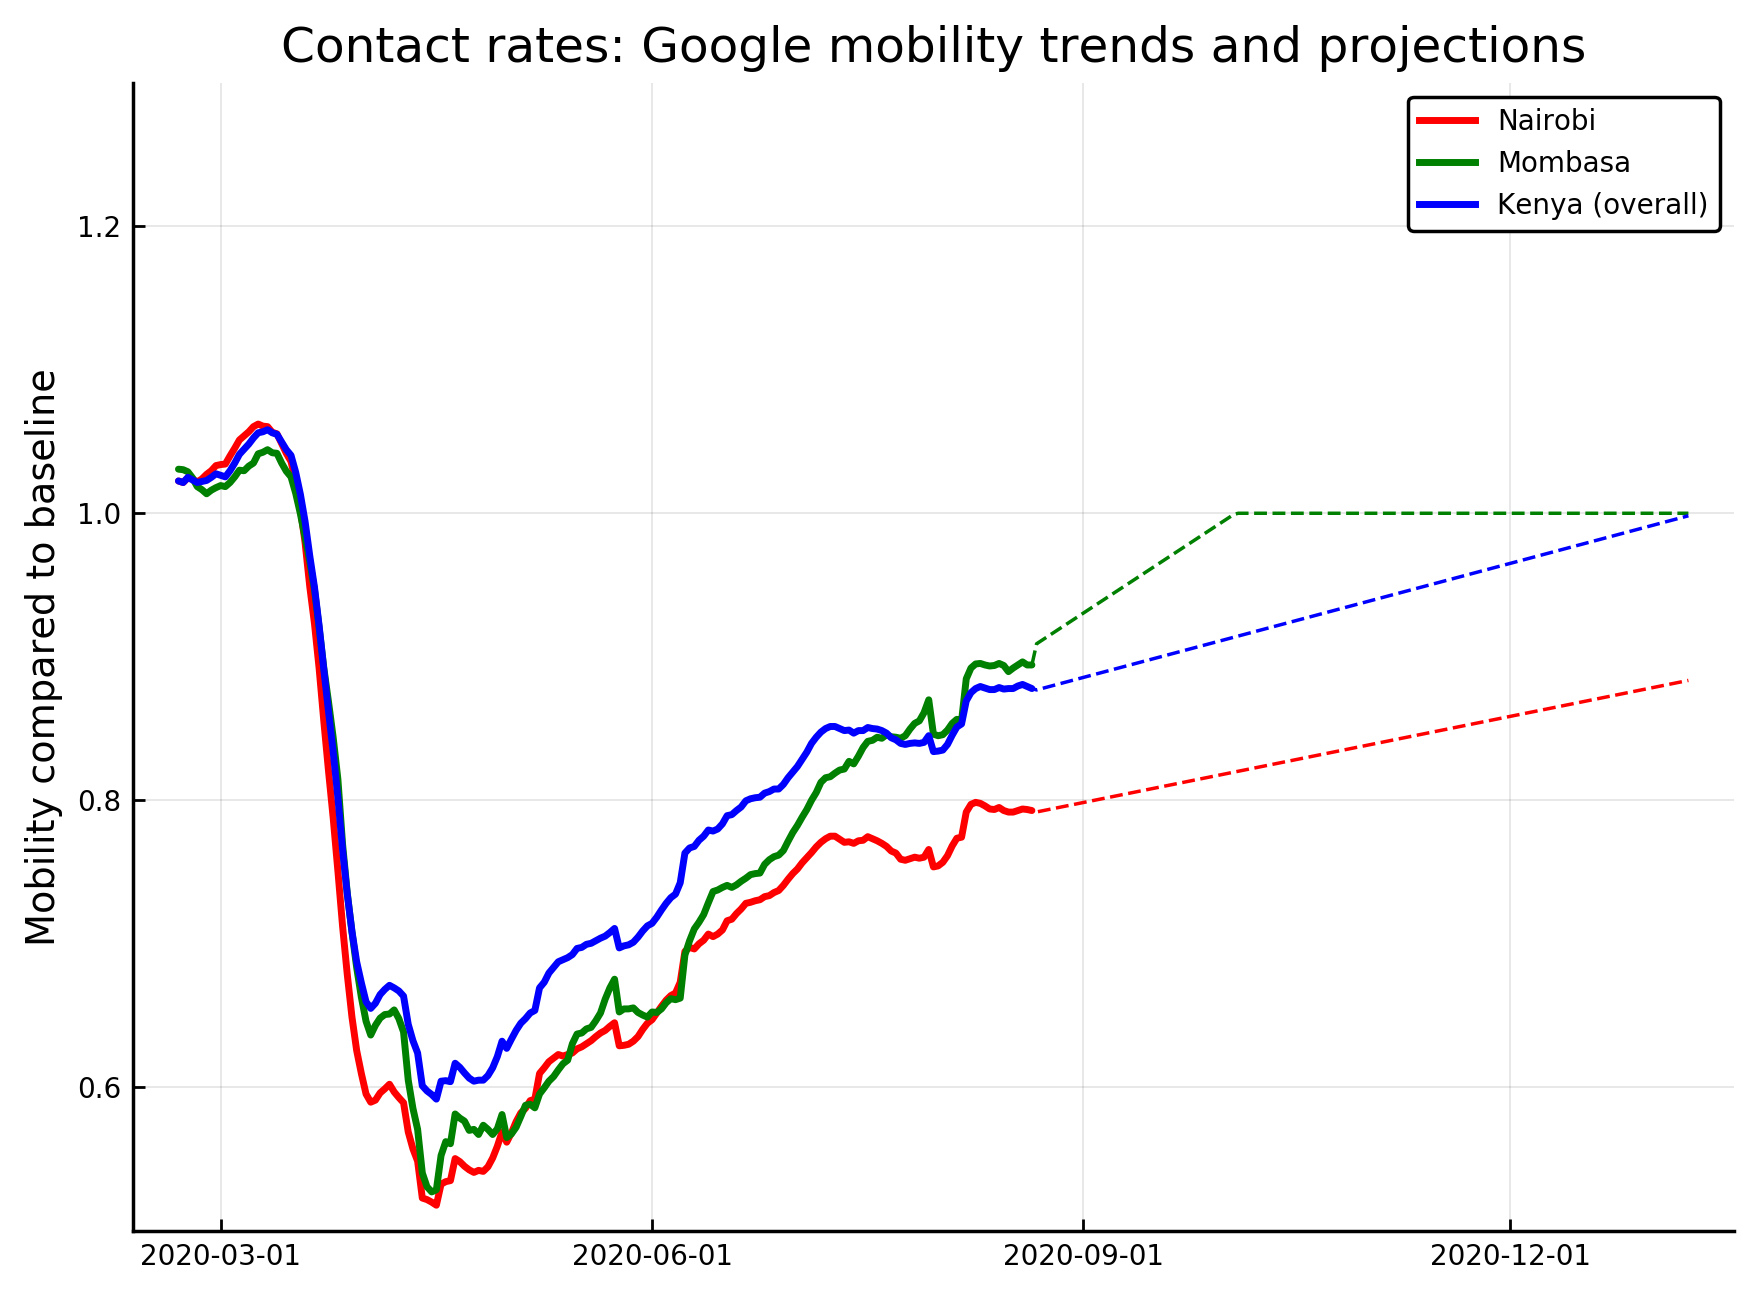

In [23]:
#Methods for doing the aggregation over relevant settings and the 

function riskycontacts_sma(df,n)
    areaname = ""
    if !ismissing(df.sub_region_1[1])
        areaname = df.sub_region_1[1]
    else
        areaname = "Kenyawide"
    end
    return (contactrate = 1 .+ sma(mean(Matrix(df[:,[9,10,12,13]]),dims = 2),n)./100, date = df.date[n:end], area = areaname)
end

function projectcontactrate(contactrate_data,fittingdate::Date,projectiondate::Date)
    f = findfirst(contactrate_nairobi.date .== fittingdate)
    ys = contactrate_data.contactrate[f:end]
    xs = collect(1:length(ys)) .-1
    fit1 = fit(xs,ys,1)
    p = Polynomial(fit1.coeffs)
    _xs = collect((length(ys)+1):((projectiondate - contactrate_nairobi.date[end]).value))
    _ys = [min(1,p(x)) for x in _xs]
    _date = [contactrate_nairobi.date[end] + Day(t) for (t,d) in enumerate(_xs)]
     # vcat(contactrate_data.contactrate,_ys)
     #
     #  vcat(contactrate_data.date,_date)
    return (contactrate = vcat(contactrate_data.contactrate,_ys) , date = vcat(contactrate_data.date,_date), area = contactrate_data.area)
end

#Aggregate over relevant settings, using 7-day moving averages then add projection
contactrate_kenya = riskycontacts_sma(Kenyawide,7)
contactrate_nairobi = riskycontacts_sma(nairobidata,7)
contactrate_mombasa = riskycontacts_sma(mombasadata,7)
projected_contactrate_nairobi = projectcontactrate(contactrate_nairobi,Date(2020,7,1),Date(2021,3,1))
projected_contactrate_mombasa = projectcontactrate(contactrate_mombasa,Date(2020,7,1),Date(2021,3,1))
projected_contactrate_kenya = projectcontactrate(contactrate_kenya,Date(2020,7,1),Date(2021,3,1))



# plot!(contactrate_nairobi.date,contactrate_nairobi.contactrate,lw=2)
plt_mob = plot(projected_contactrate_nairobi.date,projected_contactrate_nairobi.contactrate,
    ls = :dash,
    lab = "",
    color = :red,
    ylims = (0.5,1.3),
    size = (700,500),dpi = 250,
    right_margin = 1cm,
    title = "Contact rates: Google mobility trends and projections",
    ylabel = "Mobility compared to baseline")
plot!(plt_mob,projected_contactrate_mombasa.date,projected_contactrate_mombasa.contactrate,
    ls = :dash,
    lab = "",
    color = :green)
plot!(plt_mob,projected_contactrate_kenya.date,projected_contactrate_kenya.contactrate,
    ls = :dash,
    lab = "",
    color = :blue)

plot!(plt_mob,contactrate_nairobi.date,contactrate_nairobi.contactrate,
    lw = 2,
    lab = "Nairobi",
    color = :red)
plot!(plt_mob,contactrate_mombasa.date,contactrate_mombasa.contactrate,
    lw = 2,
    lab = "Mombasa",
    color = :green)
plot!(plt_mob,contactrate_kenya.date,contactrate_kenya.contactrate,
    lw = 2,
    lab = "Kenya (overall)",
    color = :blue)

savefig(plt_mob,"Kenyawidemobility_with_projections.pdf")


We use these mobility projections in the main paper.